bandit dataset shape: (25249, 36)
mdp dataset shape: (25249, 6)

final comparison:
random: 0.11%
most popular: 4.95%
ncmab: 0.02%
cmab: 0.61%
mdp: 13.91%


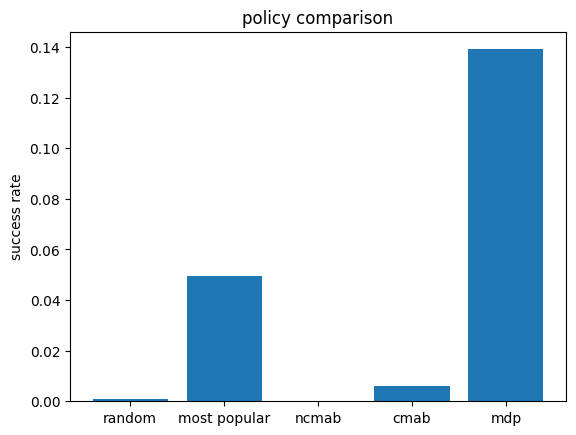

In [8]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

# load datasets
bandit_df = pd.read_csv("/content/finalencodeddsfr.csv")   # for ncmab and cmab
mdp_df = pd.read_csv("/content/mdprewards.csv")            # for mdp

print("bandit dataset shape:", bandit_df.shape)
print("mdp dataset shape:", mdp_df.shape)


# most popular coupon that appears the most
most_popular_coupon = bandit_df["coupon_id"].value_counts().idxmax()

def policy_most_popular(row=None):
    return most_popular_coupon

# random policy = choose any coupon randomly
def policy_random(row=None):
    return random.choice(bandit_df["coupon_id"].unique())

# ncmab policy = just pick coupon with highest average reward
def policy_ncmab(row=None):
    avg_rewards = bandit_df.groupby("coupon_id")["reward"].mean()
    return avg_rewards.idxmax()

# keep only demographic one-hot columns
context_cols = [col for col in bandit_df.columns if col.startswith("marital_status_")
                or col.startswith("age_range_")
                or col.startswith("family_size_")
                or col.startswith("income_bracket_")]

X = bandit_df[context_cols].values
A = bandit_df["coupon_id"].values
R = bandit_df["reward"].values

# initialize LinUCB memory
d = X.shape[1]
alpha = 0.1
actions = np.unique(A)
A_matrices = {a: np.eye(d) for a in actions}
b_vectors = {a: np.zeros(d) for a in actions}

# training loop
for i in range(len(X)):
    x_t = X[i]
    a_t = A[i]
    r_t = R[i]
    A_matrices[a_t] += np.outer(x_t, x_t)
    b_vectors[a_t] += r_t * x_t

# compute theta for each coupon
theta = {a: np.linalg.inv(A_matrices[a]).dot(b_vectors[a]) for a in actions}

def policy_cmab(row):
    x_t = row[context_cols].values
    scores = {a: theta[a].dot(x_t) for a in actions}
    return max(scores.items(), key=lambda x: x[1])[0]

# -----------------------------
# MDP policy (Q-learned result)
def policy_mdp(state):
    subset = mdp_df[mdp_df["state"] == state]
    if subset.empty:
        return random.choice(mdp_df["action"].unique())
    return subset.loc[subset["mdpreward"].idxmax()]["action"]


# evaluation

def evaluate_policy(df, policy_fn, reward_col="reward", is_mdp=False, is_cmab=False):
    success = 0
    total = 0

    for _, row in df.iterrows():
        if is_mdp:
            state = row["state"]
            rec_action = policy_fn(state)
            subset = df[df["state"] == state]
            if not subset.empty:
                best_row = subset.loc[subset[reward_col].idxmax()]
                if row["action"] == rec_action and row[reward_col] == best_row[reward_col]:
                    success += 1

        elif is_cmab:
            rec_action = policy_fn(row)
            subset = df[df["coupon_id"] == rec_action]
            if not subset.empty:
                best_reward = subset[reward_col].max()
                if row["coupon_id"] == rec_action and row[reward_col] == best_reward:
                    success += 1

        else:  # ncmab, random, most popular
            rec_action = policy_fn(row)
            subset = df[df["coupon_id"] == rec_action]
            if not subset.empty:
                best_reward = subset[reward_col].max()
                if row["coupon_id"] == rec_action and row[reward_col] == best_reward:
                    success += 1
        total += 1

    return success / total if total > 0 else 0


# run evaluations
ncmab_score = evaluate_policy(bandit_df, policy_ncmab, reward_col="reward")
cmab_score = evaluate_policy(bandit_df, policy_cmab, reward_col="reward", is_cmab=True)
mdp_score = evaluate_policy(mdp_df, policy_mdp, reward_col="mdpreward", is_mdp=True)
most_popular_score = evaluate_policy(bandit_df, policy_most_popular, reward_col="reward")
random_score = evaluate_policy(bandit_df, policy_random, reward_col="reward")


# final comparison
scores = {
    "random": random_score,
    "most popular": most_popular_score,
    "ncmab": ncmab_score,
    "cmab": cmab_score,
    "mdp": mdp_score
}

print("\nfinal comparison:")
for k, v in scores.items():
    print(f"{k}: {v:.2%}")

plt.bar(scores.keys(), scores.values())
plt.ylabel("success rate")
plt.title("policy comparison")
plt.show()





